In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [15]:
def cm_plot(y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix")

    return plt.show()

In [16]:
X_train = np.load("data/train_x.npy")
y_train = np.load("data/train_y.npy")
X_test_real = np.load("data/test_x.npy")

In [17]:
X_train.shape

(14667, 187)

In [18]:
X_test_real.shape

(7225, 187)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [20]:
%%time
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.metrics import f1_score

classifier = KNeighborsTimeSeriesClassifier(distance="euclidean")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
f1_score(y_test, y_pred, average="macro")

Wall time: 51.4 s


0.8200498034355433

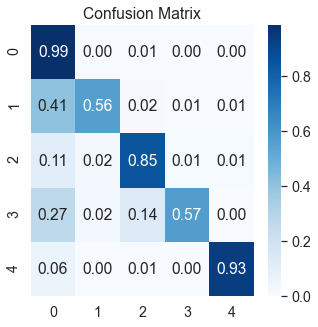

In [21]:
cm_plot(y_test, y_pred)

In [22]:
%%time
from sktime.classification.interval_based import TimeSeriesForestClassifier
from tqdm import tqdm

best_est = 3
best_f1 = 0

for est in tqdm(range(5, 42, 2)):
    for min_interval in range(3, 20):
        clf = TimeSeriesForestClassifier(n_estimators=est, min_interval=min_interval)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")

        if f1 > best_f1:
            best_f1 = f1
            best_est = est
            best_min_interval = min_interval

100%|███████████████████████████████████████████████████████████████████████████████| 19/19 [1:24:14<00:00, 266.03s/it]

Wall time: 1h 24min 14s


In [23]:
best_f1

0.8183295568357831

In [24]:
best_est

31

In [25]:
best_min_interval

17

In [28]:
clf = TimeSeriesForestClassifier(n_estimators=best_est, min_interval=best_min_interval)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.803778581541604

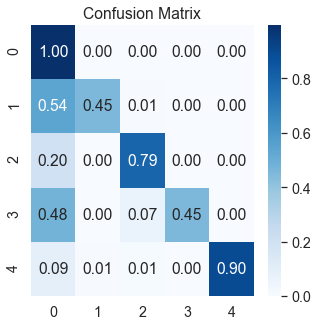

In [29]:
cm_plot(y_test, y_pred)

In [30]:
y_pred = clf.predict(X_test_real)

In [31]:
y_pred_csv = pd.DataFrame()
y_pred_csv["ID"] = np.array(range(len(y_pred))).astype(int).astype(str)
y_pred_csv["Answer"] = np.array(y_pred).astype(int).astype(str)
y_pred_csv.to_csv("testing_submission.csv", index=False)
y_pred_csv

,ID,Answer
0,0,0
1,1,0
2,2,0
3,3,2
4,4,0
...,...,...
7220,7220,0
7221,7221,2
7222,7222,0
7223,7223,0
